# Tarea Final

In [83]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Paquetes.HelperFunctions import violin_plot_numeric, null_percentage, value_counts_all_cols, train_models, validate_models
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
import lightgbm as lgb
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
import joblib
import os

# %matplotlib notebook


In [84]:
# https://www.kaggle.com/competitions/playground-series-s3e26/data?select=train.csv
# Load Dataset
df = pd.read_csv('data/train.csv')
df.head()


test_real_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/submission.csv')

In [85]:
df['Status'].value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

## Split Data

In [86]:
from sklearn.model_selection import train_test_split


# Use train_test_split to split the DataFrame
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['Status'])

test_IDs = test_df.id
test_IDs_real = test_real_df.id

# # Drop ID column
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)
test_real_df.drop(columns=['id'], inplace=True)



In [87]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


## EDA

In [88]:
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
3476,1945,D-penicillamine,14705,F,N,N,N,N,1.1,387.0,3.42,52.0,1345.0,83.70,84.0,445.0,10.6,3.0,C
486,1235,D-penicillamine,14191,F,N,Y,N,N,0.6,308.0,3.66,67.0,1214.0,52.70,101.0,309.0,9.5,2.0,C
6719,4127,Placebo,16463,F,N,N,N,N,0.7,298.0,3.40,40.0,661.0,106.95,66.0,311.0,11.3,4.0,C
12,1847,Placebo,12279,F,N,N,N,N,0.6,232.0,3.68,38.0,1029.0,128.65,99.0,273.0,10.7,2.0,C
21,326,D-penicillamine,18199,F,N,Y,Y,S,6.6,244.0,3.02,199.0,1819.0,170.50,91.0,132.0,12.1,4.0,D


In [89]:
train_df.shape

(5533, 19)

In [90]:
test_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
2340,1569,D-penicillamine,22836,F,N,Y,N,N,0.6,239.0,3.60,32.0,674.0,57.35,101.0,248.0,10.6,3.0,C
5225,2583,D-penicillamine,15265,F,N,N,N,N,1.6,652.0,4.22,20.0,622.0,85.25,85.0,442.0,10.6,2.0,C
528,2272,D-penicillamine,20510,F,N,N,N,N,0.5,622.0,4.30,28.0,622.0,60.63,213.0,213.0,9.9,2.0,C
786,2081,D-penicillamine,19126,F,N,Y,Y,N,1.3,253.0,3.56,67.0,1877.0,137.95,93.0,227.0,11.2,4.0,D
4690,515,Placebo,12544,F,N,Y,N,N,6.6,576.0,3.80,140.0,1975.0,182.90,171.0,248.0,11.0,4.0,D


In [91]:
test_df.shape

(2372, 19)

In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 3476 to 3982
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   object 
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   object 
 4   Ascites        5533 non-null   object 
 5   Hepatomegaly   5533 non-null   object 
 6   Spiders        5533 non-null   object 
 7   Edema          5533 non-null   object 
 8   Bilirubin      5533 non-null   float64
 9   Cholesterol    5533 non-null   float64
 10  Albumin        5533 non-null   float64
 11  Copper         5533 non-null   float64
 12  Alk_Phos       5533 non-null   float64
 13  SGOT           5533 non-null   float64
 14  Tryglicerides  5533 non-null   float64
 15  Platelets      5533 non-null   float64
 16  Prothrombin    5533 non-null   float64
 17  Stage          5533 non-null   float64
 18  Status    

### Check Numerical Cols

In [93]:
numeric_cols = train_df.select_dtypes(include='number')
print(len(numeric_cols.columns))

12


In [94]:
print(type(numeric_cols))

<class 'pandas.core.frame.DataFrame'>


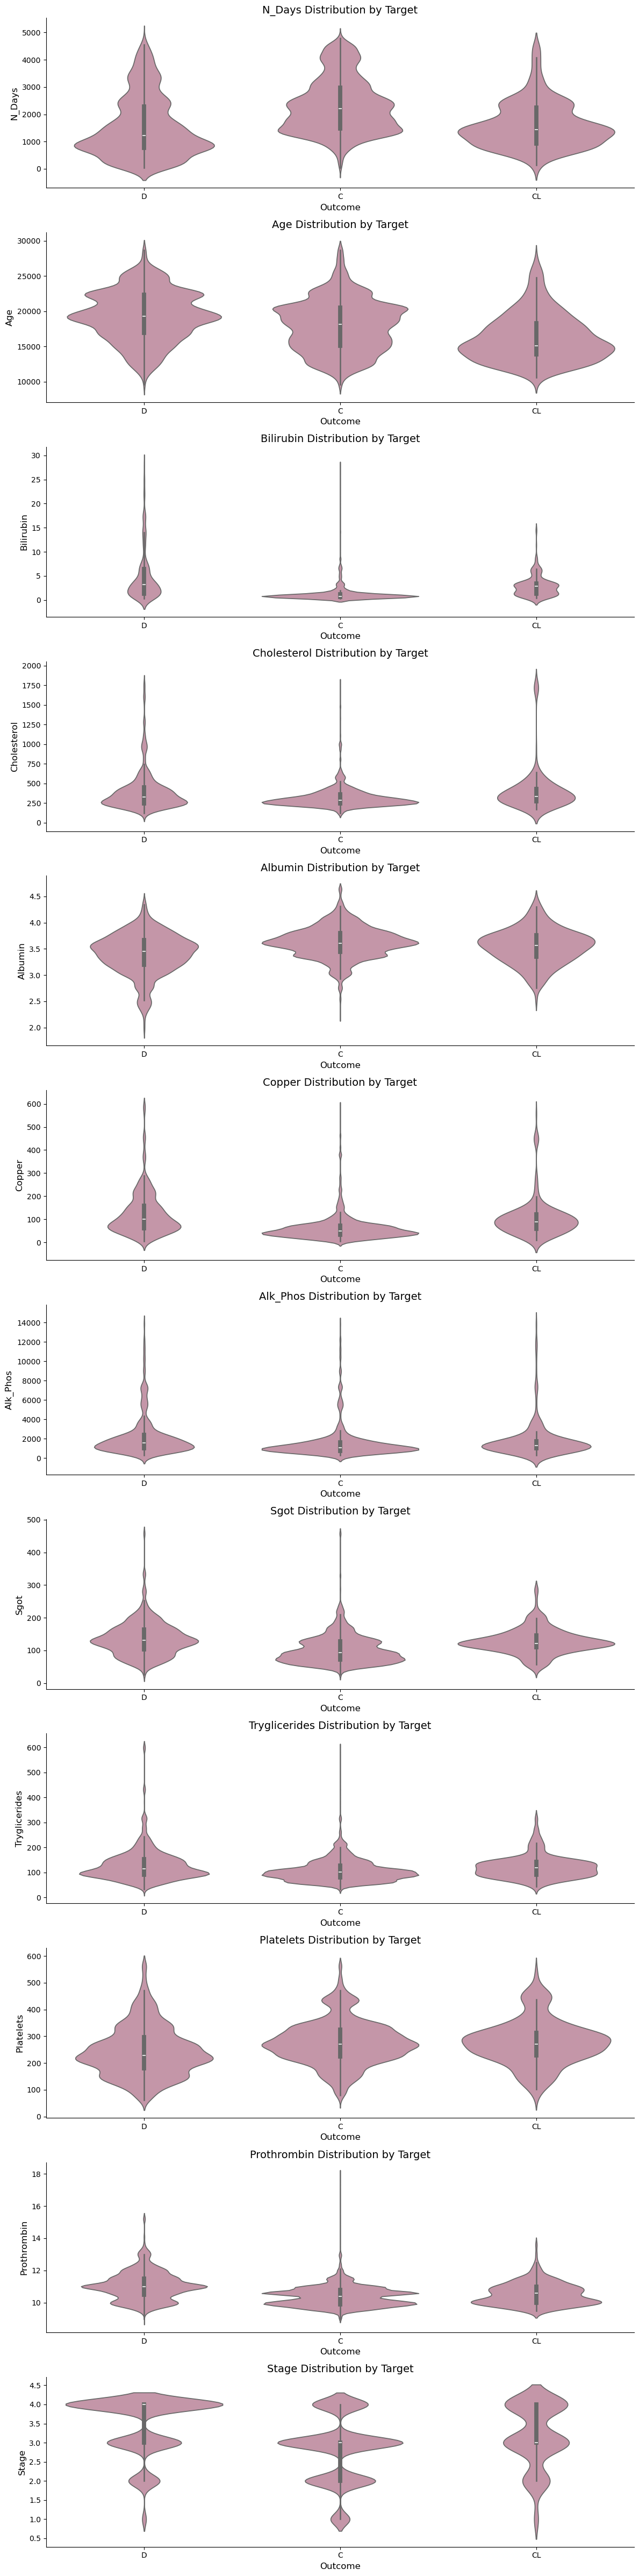

In [95]:
violin_plot_numeric(df, numeric_cols)

### Check Categorical Columns

In [96]:
cat_cols = train_df.select_dtypes(include='object')
cat_cols

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
3476,D-penicillamine,F,N,N,N,N,C
486,D-penicillamine,F,N,Y,N,N,C
6719,Placebo,F,N,N,N,N,C
12,Placebo,F,N,N,N,N,C
21,D-penicillamine,F,N,Y,Y,S,D
...,...,...,...,...,...,...,...
5997,D-penicillamine,F,N,N,N,N,C
3678,Placebo,F,N,Y,Y,N,C
3718,Placebo,F,N,Y,Y,N,D
470,D-penicillamine,F,N,Y,N,N,C


In [97]:
value_counts_all_cols(cat_cols)

Value Counts for : Drug
Placebo            2821
D-penicillamine    2712
Name: count, dtype: int64

Value Counts for : Sex
F    5126
M     407
Name: count, dtype: int64

Value Counts for : Ascites
N    5266
Y     267
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2815
N    2718
Name: count, dtype: int64

Value Counts for : Spiders
N    4175
Y    1358
Name: count, dtype: int64

Value Counts for : Edema
N    5026
S     264
Y     243
Name: count, dtype: int64

Value Counts for : Status
C     3475
D     1865
CL     193
Name: count, dtype: int64



* Drug: One-Hot Encoding
* Sex: Label encoding
* Ascites: Label Encoding
* Hepatomegaly: Label Encoding
* Spiders: Label Encoding
* Edema: One-Hot Encoding
* Status: Label Encoding

## Limpieza y Preprocesamiento de Datos

### Identificación y manejo de valores faltantes

In [98]:
null_percentage(train_df)

N_Days: total -> 0, percentage -> 0.00%
Drug: total -> 0, percentage -> 0.00%
Age: total -> 0, percentage -> 0.00%
Sex: total -> 0, percentage -> 0.00%
Ascites: total -> 0, percentage -> 0.00%
Hepatomegaly: total -> 0, percentage -> 0.00%
Spiders: total -> 0, percentage -> 0.00%
Edema: total -> 0, percentage -> 0.00%
Bilirubin: total -> 0, percentage -> 0.00%
Cholesterol: total -> 0, percentage -> 0.00%
Albumin: total -> 0, percentage -> 0.00%
Copper: total -> 0, percentage -> 0.00%
Alk_Phos: total -> 0, percentage -> 0.00%
SGOT: total -> 0, percentage -> 0.00%
Tryglicerides: total -> 0, percentage -> 0.00%
Platelets: total -> 0, percentage -> 0.00%
Prothrombin: total -> 0, percentage -> 0.00%
Stage: total -> 0, percentage -> 0.00%
Status: total -> 0, percentage -> 0.00%


* No null values in the training set

### Codificación de variable categoricas

#### One-Hot Encoding

In [99]:
from Paquetes.HelperFunctions import one_hot_encoding
one_hot_cols = ['Edema']

train_df = one_hot_encoding(train_df, one_hot_cols)
test_df = one_hot_encoding(test_df, one_hot_cols)
test_real_df = one_hot_encoding(test_real_df, one_hot_cols)

In [100]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,D-penicillamine,19724,F,N,Y,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,D-penicillamine,14975,F,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,Placebo,13149,F,N,Y,N,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,D-penicillamine,20510,F,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,D-penicillamine,21904,F,N,Y,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False


#### Label Encoding

In [101]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(train_df, le_cols)

Value Counts for : Drug
Placebo            2821
D-penicillamine    2712
Name: count, dtype: int64

Value Counts for : Sex
F    5126
M     407
Name: count, dtype: int64

Value Counts for : Ascites
N    5266
Y     267
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2815
N    2718
Name: count, dtype: int64

Value Counts for : Spiders
N    4175
Y    1358
Name: count, dtype: int64

Value Counts for : Status
C     3475
D     1865
CL     193
Name: count, dtype: int64



In [102]:
from Paquetes.HelperFunctions import label_encoding


le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
le_cols_test_real = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders']
cols_dict = {'Drug': {'D-penicillamine': 0, 'Placebo': 1}, 'Sex': {"F":0,"M":1}, 'Ascites':{'N':0,'Y':1}, 'Hepatomegaly': {'N':0,'Y':1}, 'Spiders': {'N':0,'Y':1}, 'Status': {'C':0,'D':1,'CL':2} }
cols_dict_test_real = {'Drug': {'D-penicillamine': 0, 'Placebo': 1}, 'Sex': {"F":0,"M":1}, 'Ascites':{'N':0,'Y':1}, 'Hepatomegaly': {'N':0,'Y':1}, 'Spiders': {'N':0,'Y':1} }
label_encoding(train_df, le_cols, cols_dict)
label_encoding(test_df, le_cols, cols_dict)
label_encoding(test_real_df, le_cols_test_real, cols_dict_test_real)


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,0,19724,0,0,1,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,0,14975,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,1,13149,0,0,1,0,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,0,20510,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,0,21904,0,0,1,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,2870,1,12279,0,0,0,0,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0,True,False,False
5267,1770,1,24803,0,0,0,0,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0,True,False,False
5268,3707,0,16990,0,0,1,0,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0,True,False,False
5269,1216,1,11773,0,0,0,0,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0,True,False,False


In [103]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(test_real_df, le_cols_test_real)

print(len(train_df))

Value Counts for : Drug
1    2694
0    2577
Name: count, dtype: int64

Value Counts for : Sex
0    4877
1     394
Name: count, dtype: int64

Value Counts for : Ascites
0    5027
1     244
Name: count, dtype: int64

Value Counts for : Hepatomegaly
1    2730
0    2541
Name: count, dtype: int64

Value Counts for : Spiders
0    3972
1    1299
Name: count, dtype: int64

5533


In [104]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 3476 to 3982
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   int64  
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   int64  
 4   Ascites        5533 non-null   int64  
 5   Hepatomegaly   5533 non-null   int64  
 6   Spiders        5533 non-null   int64  
 7   Bilirubin      5533 non-null   float64
 8   Cholesterol    5533 non-null   float64
 9   Albumin        5533 non-null   float64
 10  Copper         5533 non-null   float64
 11  Alk_Phos       5533 non-null   float64
 12  SGOT           5533 non-null   float64
 13  Tryglicerides  5533 non-null   float64
 14  Platelets      5533 non-null   float64
 15  Prothrombin    5533 non-null   float64
 16  Stage          5533 non-null   float64
 17  Status         5533 non-null   int64  
 18  Edema_N   

## Modelado y Evaluación

### Selección de Características

In [105]:
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y
3476,1945,0,14705,0,0,0,0,1.1,387.0,3.42,52.0,1345.0,83.70,84.0,445.0,10.6,3.0,0,True,False,False
486,1235,0,14191,0,0,1,0,0.6,308.0,3.66,67.0,1214.0,52.70,101.0,309.0,9.5,2.0,0,True,False,False
6719,4127,1,16463,0,0,0,0,0.7,298.0,3.40,40.0,661.0,106.95,66.0,311.0,11.3,4.0,0,True,False,False
12,1847,1,12279,0,0,0,0,0.6,232.0,3.68,38.0,1029.0,128.65,99.0,273.0,10.7,2.0,0,True,False,False
21,326,0,18199,0,0,1,1,6.6,244.0,3.02,199.0,1819.0,170.50,91.0,132.0,12.1,4.0,2,False,True,False


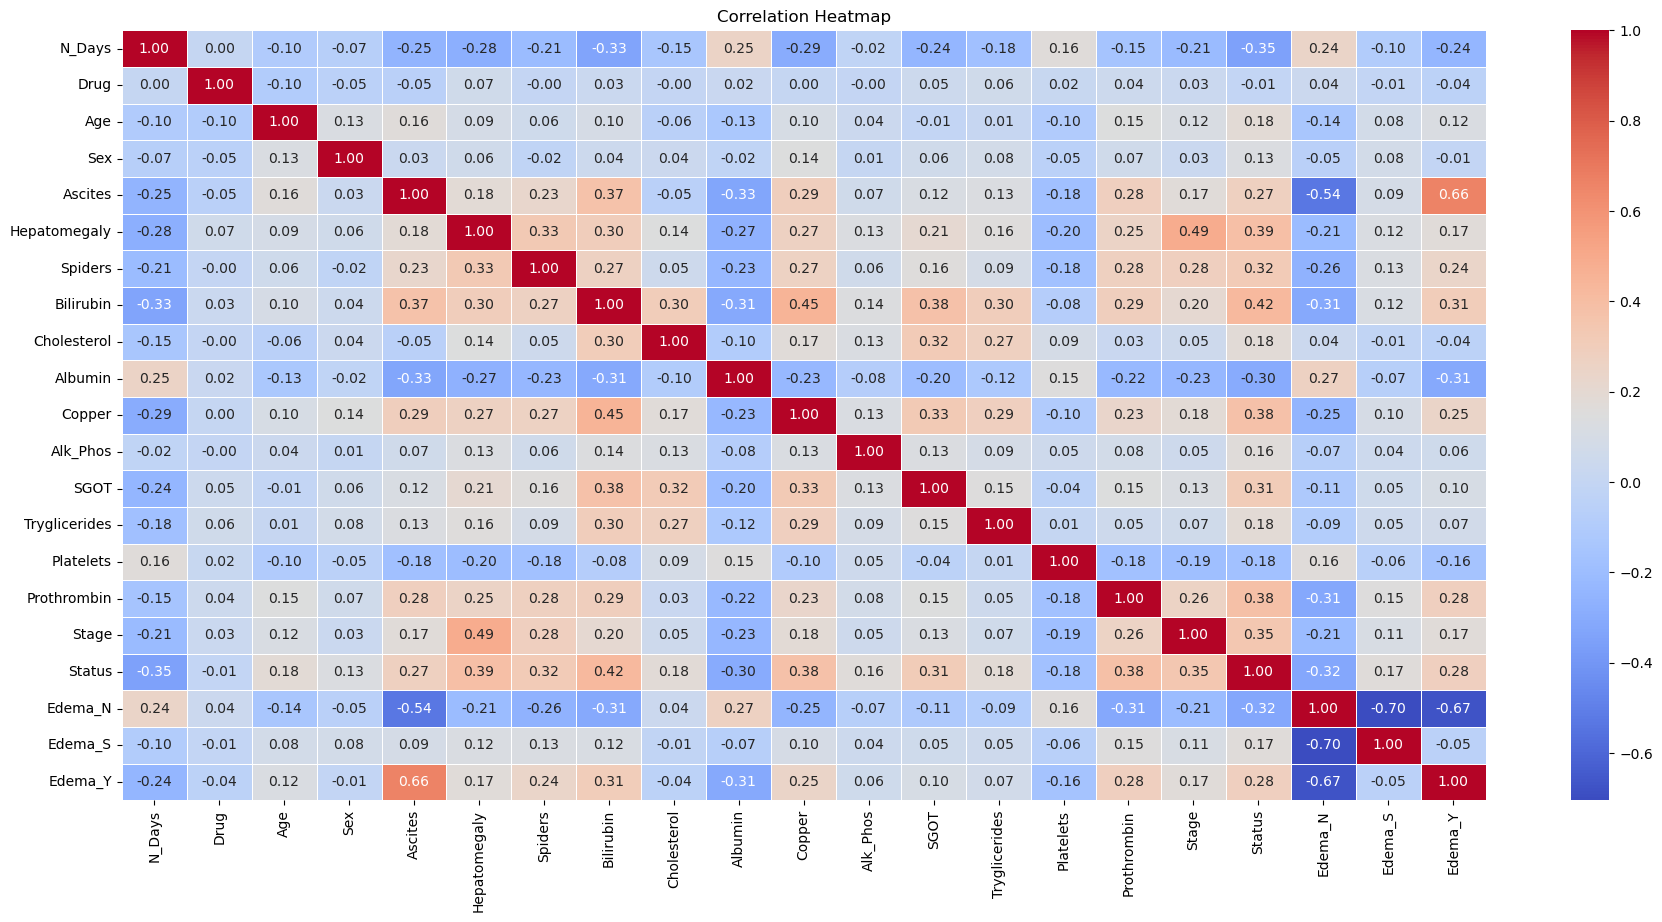

In [106]:
from Paquetes.HelperFunctions import corr_heatmap

corr = corr_heatmap(train_df)

In [107]:
LABEL = "Status"
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in train_df.columns if x not in CAT_FEATS and x != LABEL]

### Feature Engineering

In [108]:

class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 365.25).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Use years from above, min=26, max=78
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    # Placeholder concept, assuming 'Bilirubin' improvement is a measure of effectiveness
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    # From data set explanations above let's add all the "bad" symptoms
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])
        # Drop the original symptom columns and add the new encoded features
        # X_transformed.drop(columns=self.symptom_columns, inplace=True)
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

# Define the pipeline
pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('age_groups', AgeGroupsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer()),
    #('scaling', ScalingTransformer()),
    # ... ?
])

# Apply the pipeline to your dataframes
train_df_mod = pipeline.fit_transform(train_df)
test_df_mod = pipeline.transform(test_df)
test_df_real_mod = pipeline.transform(test_real_df)

train_df_mod['Symptom_Score'] = pd.to_numeric(train_df_mod['Symptom_Score'], errors='coerce')
test_df_mod['Symptom_Score'] = pd.to_numeric(test_df_mod['Symptom_Score'], errors='coerce')
test_df_real_mod['Symptom_Score'] = pd.to_numeric(test_df_real_mod['Symptom_Score'], errors='coerce')

# Update the CAT_FEATS
CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', #old
             'Age_Group', 'Symptom_Score'] # new 
# Update the NUM_FEATS ????

In [109]:
train_df_mod.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_000FalseFalseTrue,Symptom_Score_000FalseTrueFalse,Symptom_Score_000TrueFalseFalse,Symptom_Score_001FalseFalseTrue,Symptom_Score_001FalseTrueFalse,Symptom_Score_001TrueFalseFalse,Symptom_Score_010FalseFalseTrue,Symptom_Score_010FalseTrueFalse,Symptom_Score_010TrueFalseFalse,Symptom_Score_011FalseFalseTrue,Symptom_Score_011FalseTrueFalse,Symptom_Score_011TrueFalseFalse,Symptom_Score_100FalseFalseTrue,Symptom_Score_100FalseTrueFalse,Symptom_Score_101FalseFalseTrue,Symptom_Score_101FalseTrueFalse,Symptom_Score_101TrueFalseFalse,Symptom_Score_110FalseFalseTrue,Symptom_Score_110FalseTrueFalse,Symptom_Score_110TrueFalseFalse,Symptom_Score_111FalseFalseTrue,Symptom_Score_111FalseTrueFalse,Symptom_Score_111TrueFalseFalse,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
3476,1945,0,14705,0,0,0,0,1.1,387.0,3.42,52.0,1345.0,83.70,84.0,445.0,10.6,3.0,0,True,False,False,12760,40,1,3.762,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,358.3050,-1340.48,5,4
486,1235,0,14191,0,0,1,0,0.6,308.0,3.66,67.0,1214.0,52.70,101.0,309.0,9.5,2.0,0,True,False,False,12956,39,1,2.196,0.0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,317.7400,-1209.74,3,4
6719,4127,1,16463,0,0,0,0,0.7,298.0,3.40,40.0,661.0,106.95,66.0,311.0,11.3,4.0,0,True,False,False,12336,45,1,2.380,0.7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193.0125,-656.90,11,3
12,1847,1,12279,0,0,0,0,0.6,232.0,3.68,38.0,1029.0,128.65,99.0,273.0,10.7,2.0,0,True,False,False,10432,34,1,2.208,0.6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,290.4825,-1024.72,5,0
21,326,0,18199,0,0,1,1,6.6,244.0,3.02,199.0,1819.0,170.50,91.0,132.0,12.1,4.0,2,False,True,False,17873,50,2,19.932,0.0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,499.7800,-1809.38,0,10


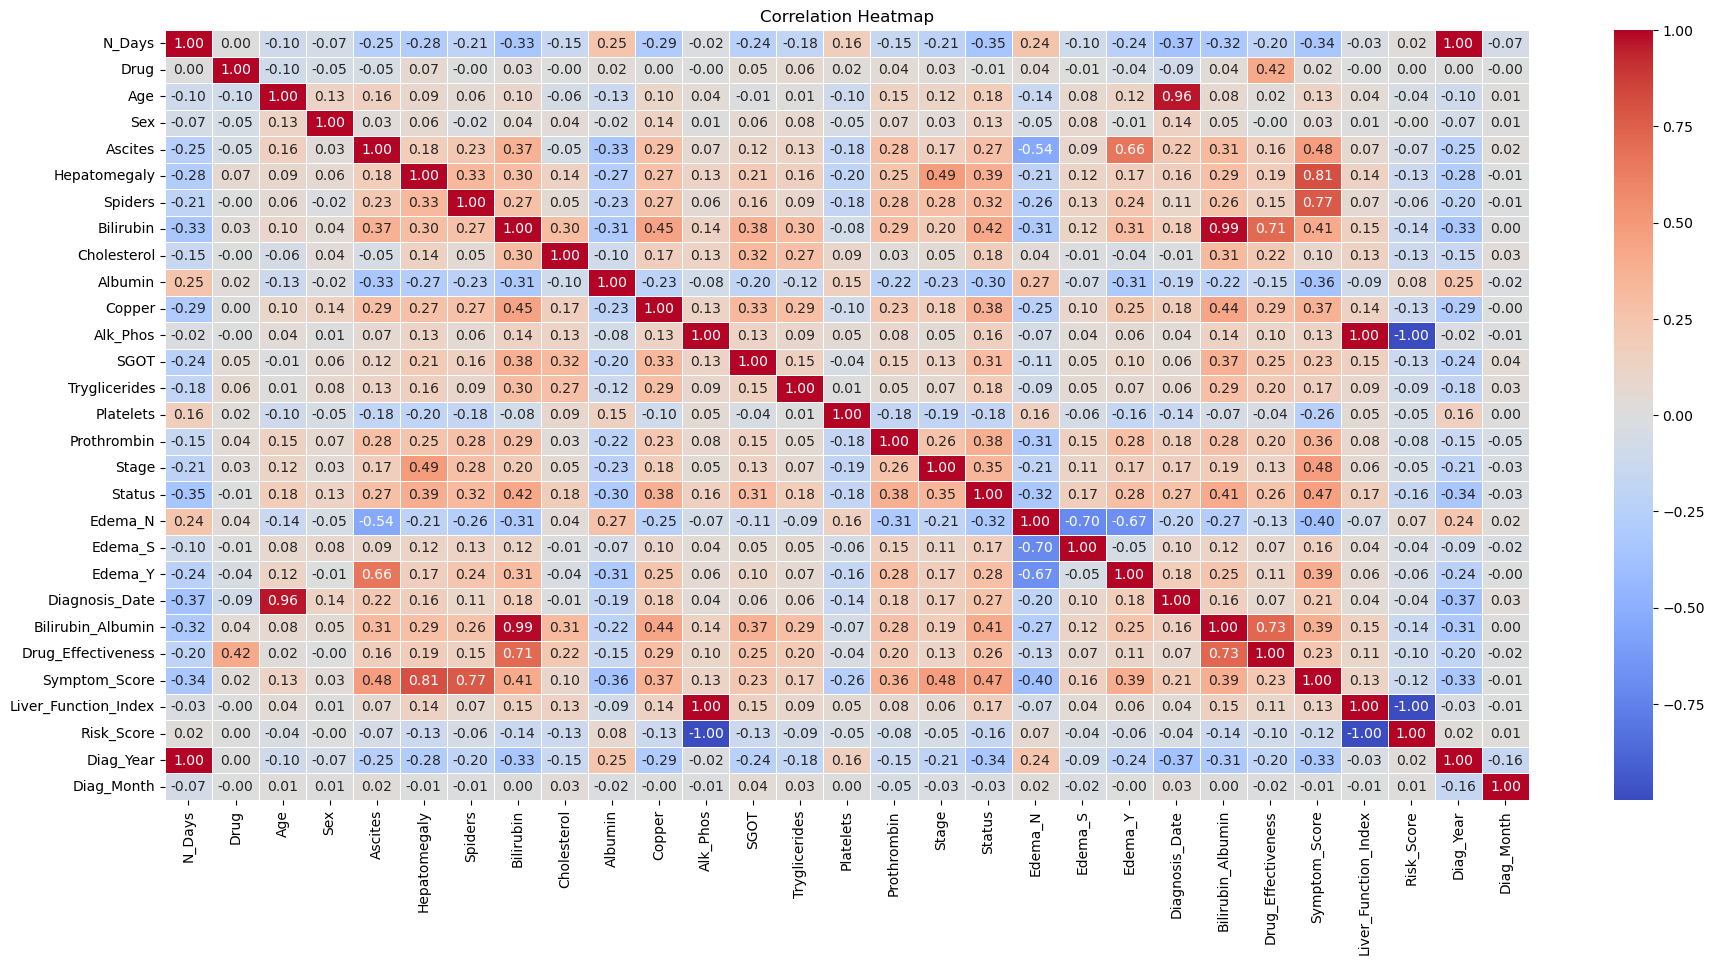

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
N_Days,1.000000,0.001724,-0.103944,-0.070987,-0.252916,-0.279005,-0.206841,-0.333953,-0.145010,0.251660,-0.293861,-0.019727,-0.243453,-0.180742,0.164282,-0.152325,-0.212801,-0.345317,0.243830,-0.097803,-0.241559,-0.373932,-0.317434,-0.204778,-0.336758,-0.026468,0.019126,0.995387,-0.068920
Drug,0.001724,1.000000,-0.095345,-0.049177,-0.052517,0.065645,-0.001996,0.029752,-0.002242,0.023548,0.001382,-0.002618,0.045640,0.063929,0.015961,0.043954,0.030803,-0.006990,0.036960,-0.007803,-0.043921,-0.089387,0.039352,0.420929,0.024663,-0.001381,0.002681,0.002258,-0.004166
Age,-0.103944,-0.095345,1.000000,0.127330,0.161742,0.093657,0.055135,0.095680,-0.055491,-0.128290,0.102231,0.040155,-0.010606,0.013707,-0.104627,0.145175,0.118232,0.181675,-0.142120,0.075826,0.121219,0.961300,0.077139,0.015796,0.125331,0.039892,-0.040002,-0.103472,0.008967
Sex,-0.070987,-0.049177,0.127330,1.000000,0.030238,0.064995,-0.022350,0.043717,0.036651,-0.022571,0.144755,0.005035,0.062056,0.076280,-0.049089,0.066899,0.031827,0.129439,-0.054487,0.079836,-0.006334,0.138400,0.049436,-0.003259,0.034968,0.006681,-0.004955,-0.070833,0.005843
Ascites,-0.252916,-0.052517,0.161742,0.030238,1.000000,0.182459,0.226282,0.369356,-0.054351,-0.328337,0.288530,0.065679,0.117067,0.129147,-0.180463,0.284476,0.170153,0.274749,-0.536496,0.088071,0.663739,0.220884,0.314482,0.164558,0.479952,0.069072,-0.065035,-0.251759,0.020131
Hepatomegaly,-0.279005,0.065645,0.093657,0.064995,0.182459,1.000000,0.331911,0.296384,0.143480,-0.267974,0.271101,0.129933,0.205282,0.156391,-0.198701,0.248659,0.490988,0.392651,-0.211842,0.123277,0.170023,0.164621,0.288267,0.190698,0.812260,0.135199,-0.129437,-0.275248,-0.005547
Spiders,-0.206841,-0.001996,0.055135,-0.022350,0.226282,0.331911,1.000000,0.269644,0.049122,-0.233190,0.266837,0.061354,0.159500,0.088548,-0.177575,0.279420,0.284391,0.317850,-0.262844,0.126498,0.238480,0.108709,0.260150,0.150914,0.768074,0.065670,-0.060885,-0.203025,-0.014284
Bilirubin,-0.333953,0.029752,0.095680,0.043717,0.369356,0.296384,0.269644,1.000000,0.304448,-0.309977,0.450899,0.137703,0.375644,0.300008,-0.081774,0.291763,0.201916,0.421907,-0.306425,0.120350,0.306234,0.181728,0.988245,0.712938,0.409030,0.148646,-0.135843,-0.330357,0.004418
Cholesterol,-0.145010,-0.002242,-0.055491,0.036651,-0.054351,0.143480,0.049122,0.304448,1.000000,-0.096599,0.169062,0.126213,0.318263,0.274909,0.091541,0.025519,0.052696,0.175481,0.038469,-0.013366,-0.040258,-0.011577,0.314525,0.222265,0.096753,0.134423,-0.125669,-0.145882,0.026392
Albumin,0.251660,0.023548,-0.128290,-0.022571,-0.328337,-0.267974,-0.233190,-0.309977,-0.096599,1.000000,-0.225923,-0.084801,-0.201934,-0.120241,0.154060,-0.223505,-0.234985,-0.298894,0.267874,-0.066545,-0.307928,-0.189342,-0.223508,-0.146949,-0.362950,-0.090049,0.084399,0.250961,-0.023356


In [110]:
corr_heatmap(train_df_mod)

In [111]:
label_encoder = LabelEncoder()
def tsne_with_feature_selection_and_pca(data, num_feats, target_column, n_components=2, top_n_features=10, pca_components=None):
    """
    Select top features based on feature importance, optionally apply PCA, and then use t-SNE for visualization.

    Parameters:
    data (DataFrame): The input data.
    num_feats (list): List of numerical feature column names.
    target_column (str): The name of the target column.
    n_components (int): Number of dimensions for t-SNE (2 or 3). Default is 2.
    top_n_features (int): Number of top features to select based on importance. Default is 10.
    pca_components (int or None): Number of PCA components to retain before applying t-SNE. If None, PCA is not applied.
    """
    
    global label_encoder
    
    # Standardizing the numerical features
    scaler = StandardScaler()
    numerical_data_scaled = scaler.fit_transform(data[num_feats])

    # Random Forest for feature importances
    rf = RandomForestClassifier(random_state=42)
    rf.fit(numerical_data_scaled, data[target_column])
    importances = rf.feature_importances_

    # Selecting top_n_features
    indices = np.argsort(importances)[-top_n_features:]
    selected_features = [num_feats[i] for i in indices]

    # Data for t-SNE
    tsne_data = numerical_data_scaled[:, indices]

    # Optionally applying PCA
    if pca_components is not None and pca_components < len(selected_features):
        pca = PCA(n_components=pca_components)
        tsne_data = pca.fit_transform(tsne_data)

    # Applying t-SNE
    tsne = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(tsne_data)

    # Creating a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=[f'Component {i+1}' for i in range(n_components)])
    tsne_df[target_column] = label_encoder.inverse_transform(data[target_column].values)

    # Visualizing using Plotly
    if n_components == 3:
        fig = px.scatter_3d(tsne_df, x='Component 1', y='Component 2', z='Component 3', color=target_column)
    else:
        fig = px.scatter(tsne_df, x='Component 1', y='Component 2', color=target_column)
    
    fig.update_layout(width=800, height=600)
    fig.show()

train_df_red = train_df_mod
# tsne_with_feature_selection_and_pca(train_df_red, NUM_FEATS, LABEL, n_components=3, top_n_features=10, pca_components=None)

In [112]:
# Features to combine 
# All
#df_train_pca = df_train_mod.drop([LABEL], axis=1)
#df_test_pca = df_test_mod

# Numerical feats
df_train_pca = train_df_mod[NUM_FEATS]
df_test_pca = test_df_mod[NUM_FEATS]
test_real_df_pca = test_df_real_mod[NUM_FEATS]

# Some, the feats here are taken iteratively from previous runs
#FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days']
#PCA_FEATS = [c for c in df_train_mod.drop(LABEL, axis=1).columns.values if c not in FEATS]
#df_train_pca = df_train_mod[PCA_FEATS]
#df_test_pca = df_test_mod[PCA_FEATS]

pca = PCA(n_components=3)
df_train_pca = pca.fit_transform(df_train_pca)
df_test_pca = pca.transform(df_test_pca)
test_real_df_pca = pca.transform(test_real_df_pca)

print(f"Explained variance per component: {np.round(pca.explained_variance_ratio_, 1)}")

Explained variance per component: [0.7 0.2 0.1]


In [113]:
eps_expl_var_treshold = 0
n_pcas = np.sum(np.round(pca.explained_variance_ratio_, 3) > eps_expl_var_treshold)
pca_c_names = [f"PCA_{i}" for i in range(n_pcas)]
print(f"PCA column names: {pca_c_names}")
train_df_mod[pca_c_names] = df_train_pca[:,0:n_pcas]
test_df_mod[pca_c_names] = df_test_pca[:,0:n_pcas]
test_df_real_mod[pca_c_names] = test_real_df_pca[:,0:n_pcas]

PCA column names: ['PCA_0', 'PCA_1', 'PCA_2']


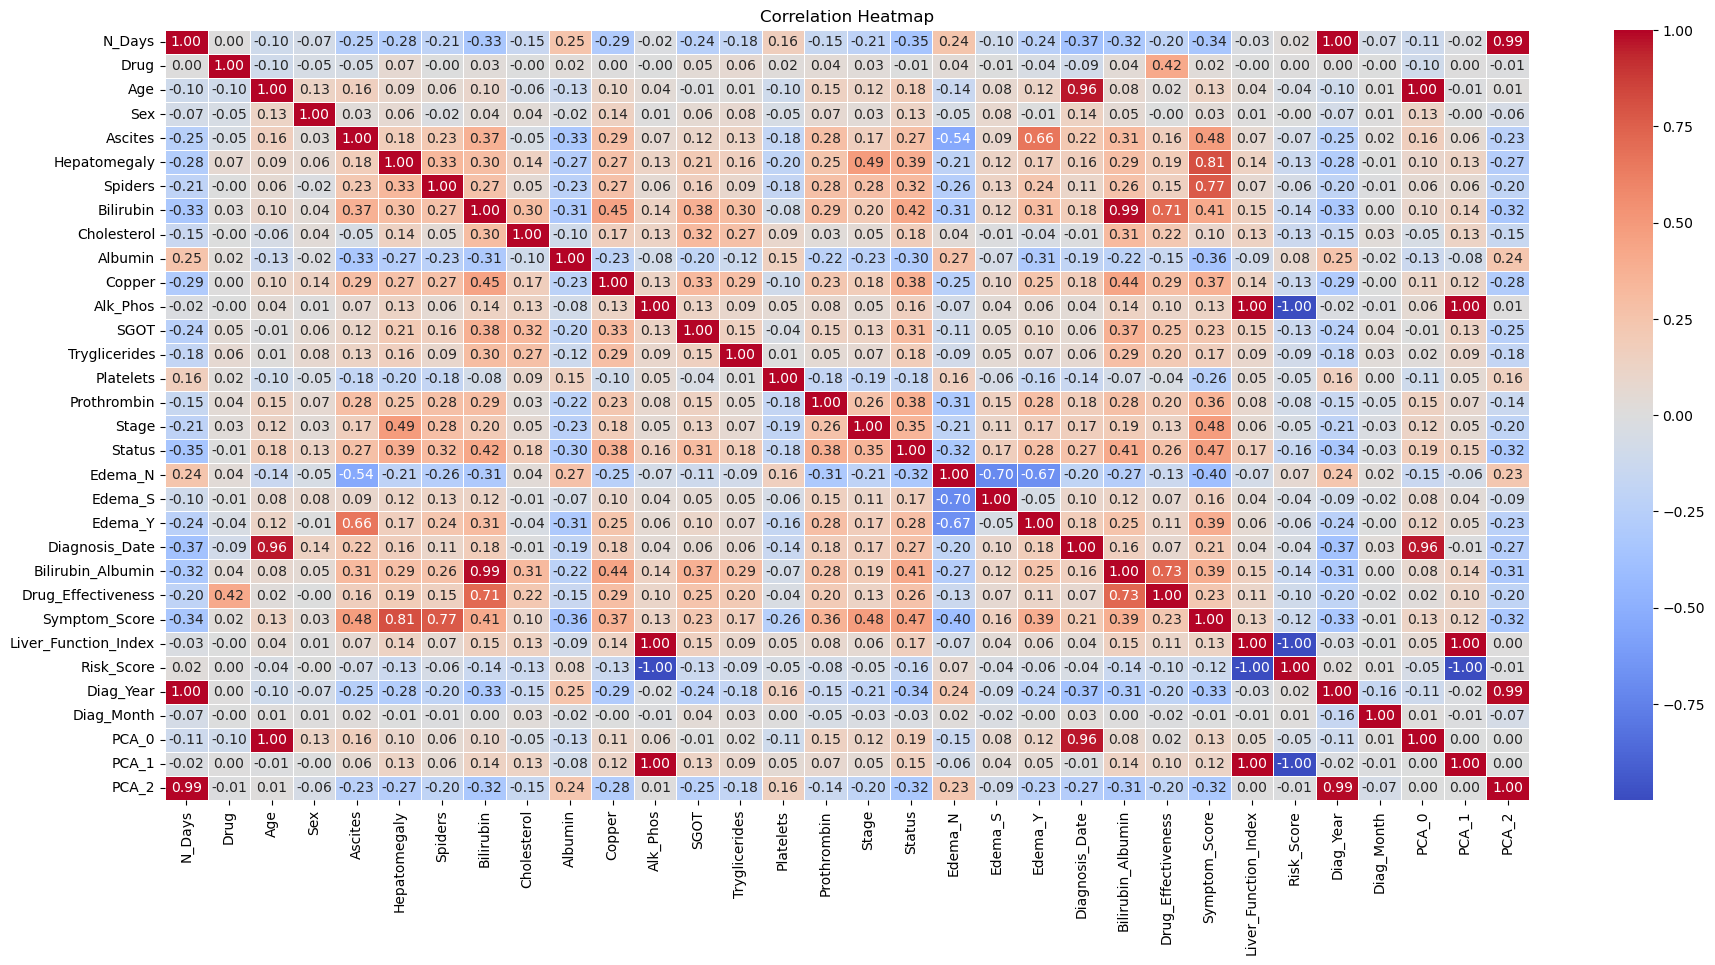

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month,PCA_0,PCA_1,PCA_2
N_Days,1.000000,0.001724,-0.103944,-0.070987,-0.252916,-0.279005,-0.206841,-0.333953,-0.145010,0.251660,-0.293861,-0.019727,-0.243453,-0.180742,0.164282,-0.152325,-0.212801,-0.345317,0.243830,-0.097803,-0.241559,-0.373932,-0.317434,-0.204778,-0.336758,-0.026468,0.019126,0.995387,-0.068920,-1.141015e-01,-2.117231e-02,9.932298e-01
Drug,0.001724,1.000000,-0.095345,-0.049177,-0.052517,0.065645,-0.001996,0.029752,-0.002242,0.023548,0.001382,-0.002618,0.045640,0.063929,0.015961,0.043954,0.030803,-0.006990,0.036960,-0.007803,-0.043921,-0.089387,0.039352,0.420929,0.024663,-0.001381,0.002681,0.002258,-0.004166,-9.522791e-02,2.694112e-03,-9.156071e-03
Age,-0.103944,-0.095345,1.000000,0.127330,0.161742,0.093657,0.055135,0.095680,-0.055491,-0.128290,0.102231,0.040155,-0.010606,0.013707,-0.104627,0.145175,0.118232,0.181675,-0.142120,0.075826,0.121219,0.961300,0.077139,0.015796,0.125331,0.039892,-0.040002,-0.103472,0.008967,9.998395e-01,-1.493943e-02,9.889040e-03
Sex,-0.070987,-0.049177,0.127330,1.000000,0.030238,0.064995,-0.022350,0.043717,0.036651,-0.022571,0.144755,0.005035,0.062056,0.076280,-0.049089,0.066899,0.031827,0.129439,-0.054487,0.079836,-0.006334,0.138400,0.049436,-0.003259,0.034968,0.006681,-0.004955,-0.070833,0.005843,1.278918e-01,-1.487876e-03,-5.721382e-02
Ascites,-0.252916,-0.052517,0.161742,0.030238,1.000000,0.182459,0.226282,0.369356,-0.054351,-0.328337,0.288530,0.065679,0.117067,0.129147,-0.180463,0.284476,0.170153,0.274749,-0.536496,0.088071,0.663739,0.220884,0.314482,0.164558,0.479952,0.069072,-0.065035,-0.251759,0.020131,1.649902e-01,5.843130e-02,-2.344952e-01
Hepatomegaly,-0.279005,0.065645,0.093657,0.064995,0.182459,1.000000,0.331911,0.296384,0.143480,-0.267974,0.271101,0.129933,0.205282,0.156391,-0.198701,0.248659,0.490988,0.392651,-0.211842,0.123277,0.170023,0.164621,0.288267,0.190698,0.812260,0.135199,-0.129437,-0.275248,-0.005547,9.821178e-02,1.269466e-01,-2.678385e-01
Spiders,-0.206841,-0.001996,0.055135,-0.022350,0.226282,0.331911,1.000000,0.269644,0.049122,-0.233190,0.266837,0.061354,0.159500,0.088548,-0.177575,0.279420,0.284391,0.317850,-0.262844,0.126498,0.238480,0.108709,0.260150,0.150914,0.768074,0.065670,-0.060885,-0.203025,-0.014284,5.803426e-02,5.985928e-02,-2.008664e-01
Bilirubin,-0.333953,0.029752,0.095680,0.043717,0.369356,0.296384,0.269644,1.000000,0.304448,-0.309977,0.450899,0.137703,0.375644,0.300008,-0.081774,0.291763,0.201916,0.421907,-0.306425,0.120350,0.306234,0.181728,0.988245,0.712938,0.409030,0.148646,-0.135843,-0.330357,0.004418,1.008770e-01,1.352714e-01,-3.236215e-01
Cholesterol,-0.145010,-0.002242,-0.055491,0.036651,-0.054351,0.143480,0.049122,0.304448,1.000000,-0.096599,0.169062,0.126213,0.318263,0.274909,0.091541,0.025519,0.052696,0.175481,0.038469,-0.013366,-0.040258,-0.011577,0.314525,0.222265,0.096753,0.134423,-0.125669,-0.145882,0.026392,-5.220652e-02,1.317480e-01,-1.539323e-01
Albumin,0.251660,0.023548,-0.128290,-0.022571,-0.328337,-0.267974,-0.233190,-0.309977,-0.096599,1.000000,-0.225923,-0.084801,-0.201934,-0.120241,0.154060,-0.223505,-0.234985,-0.298894,0.267874,-0.066545,-0.307928,-0.189342,-0.223508,-0.146949,-0.362950,-0.090049,0.084399,0.250961,-0.023356,-1.318433e-01,-7.960900e-02,2.371927e-01


In [114]:
corr_heatmap(train_df_mod)

In [115]:
train_df_mod.columns

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status',
       'Edema_N', 'Edema_S', 'Edema_Y', 'Diagnosis_Date', 'Age_Years',
       'Age_Group', 'Bilirubin_Albumin', 'Drug_Effectiveness', 'Symptom_Score',
       'Symptom_Score_000FalseFalseTrue', 'Symptom_Score_000FalseTrueFalse',
       'Symptom_Score_000TrueFalseFalse', 'Symptom_Score_001FalseFalseTrue',
       'Symptom_Score_001FalseTrueFalse', 'Symptom_Score_001TrueFalseFalse',
       'Symptom_Score_010FalseFalseTrue', 'Symptom_Score_010FalseTrueFalse',
       'Symptom_Score_010TrueFalseFalse', 'Symptom_Score_011FalseFalseTrue',
       'Symptom_Score_011FalseTrueFalse', 'Symptom_Score_011TrueFalseFalse',
       'Symptom_Score_100FalseFalseTrue', 'Symptom_Score_100FalseTrueFalse',
       'Symptom_Score_101FalseFalseTrue', 'Symptom_Score_101FalseTrueFalse',
       'S

In [116]:
# All
# FEATS = df_train_mod.drop(LABEL, axis=1).columns.tolist()
# Some
# FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
#          'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 
#          'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']
FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
         'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage']

# Columns to exclude
# exlcude_columns = ['Edema_N', 'Platelets', 'Albumin', 'N_Days', 'Diag_year', 'Risk_Score', 'Diag_Month', 'PCA_0','PCA_1','PCA_2','PCA_3', 'Status']
exlcude_columns = ['Edema_N', 'Platelets', 'Albumin', 'N_Days', 'Diag_year', 'Risk_Score', 'Diag_Month', 'PCA_0','PCA_1','PCA_2','PCA_3', 'Status', 'Age_Group',
                   'Spiders', 'Hepatomegaly','Symptom_Score', 'Drug_Effectiveness', 'Stage', 'Sex', 'Symptom_Score_000FalseFalseTrue', 'Symptom_Score_000FalseTrueFalse',
                   'Symptom_Score_000TrueFalseFalse', 'Symptom_Score_001FalseFalseTrue',
                   'Symptom_Score_001FalseTrueFalse', 'Symptom_Score_001TrueFalseFalse',
                   'Symptom_Score_010FalseFalseTrue', 'Symptom_Score_010FalseTrueFalse',
                   'Symptom_Score_010TrueFalseFalse', 'Symptom_Score_011FalseFalseTrue',
                   'Symptom_Score_011FalseTrueFalse', 'Symptom_Score_011TrueFalseFalse',
                   'Symptom_Score_100FalseFalseTrue', 'Symptom_Score_100FalseTrueFalse',
                   'Symptom_Score_100TrueFalseFalse', 'Symptom_Score_101FalseFalseTrue',
                   'Symptom_Score_101FalseTrueFalse', 'Symptom_Score_101TrueFalseFalse',
                   'Symptom_Score_110FalseFalseTrue', 'Symptom_Score_110FalseTrueFalse',
                   'Symptom_Score_110TrueFalseFalse', 'Symptom_Score_111FalseFalseTrue',
                   'Symptom_Score_111FalseTrueFalse', 'Symptom_Score_111TrueFalseFalse',
                   'Ascites', 'Drug', 'Edema_Y','PCA_0', 'PCA_1', 'PCA_2', 'PCA_3']
FEATS2 = list(set(train_df_mod)-set(exlcude_columns))

FEATS_PCA = ['PCA_0','PCA_1','PCA_2']

# FEATS = FEATS + pca_c_names
# FEATS = sel_feats.tolist()
print(f"Number of feats: {len(FEATS)}")
print(f"Features used: {FEATS}")

print(f"\nNumber of feats 2: {len(FEATS2)}")
print(f"Features used 2: {FEATS2}")



Number of feats: 14
Features used: ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage']

Number of feats 2: 14
Features used 2: ['Age', 'Bilirubin', 'Cholesterol', 'Tryglicerides', 'Bilirubin_Albumin', 'SGOT', 'Diag_Year', 'Prothrombin', 'Age_Years', 'Liver_Function_Index', 'Copper', 'Edema_S', 'Diagnosis_Date', 'Alk_Phos']


In [117]:
# Just use the selected features
df_train_final = train_df_mod[FEATS + [LABEL]]
df_test_final = test_df_mod[FEATS+[LABEL]]
test_real_df_final = test_df_real_mod[FEATS]

# df_train_final2 = train_df_mod[FEATS2 + [LABEL]]
# df_test_final2 = test_df_mod[FEATS2+[LABEL]]
# test_real_df_final2 = test_df_real_mod[FEATS2]

# df_train_final_pca = train_df_mod[FEATS_PCA + [LABEL]]
# df_test_final_pca = test_df_mod[FEATS_PCA+[LABEL]]
# test_real_df_final_pca = test_df_real_mod[FEATS_PCA]



In [118]:
# Get X and y variables
X = df_train_final.drop('Status', axis=1)
y = df_train_final['Status']


In [119]:
y.value_counts()

Status
0    3475
2    1865
1     193
Name: count, dtype: int64

### Oversampling and Undersampling

In [120]:
# Define over and undersampling strategy
over_strategy1 = {0:3475, 1:800, 2: 1865}
under_strategy1 = {0:1865, 1:800, 2: 1865}

# Initialize SMOTE (Oversampling) and RandomUnderSampler (Undersampling) with their strategies
over = SMOTE(sampling_strategy=over_strategy1)
under = RandomUnderSampler(sampling_strategy=under_strategy1)

# Perform oversampling
X_res, y_res = over.fit_resample(X, y)

# Perform undersampling
X_res, y_res = under.fit_resample(X_res, y_res)


In [121]:
# Check target variable after over and under sampling
y_res.value_counts()

Status
0    1865
2    1865
1     800
Name: count, dtype: int64

In [122]:
# Update final training set
df_train_final = pd.concat([X_res, y_res], axis=1)


## Creación de Modelo

In [123]:
# Initialize classifiers
xgb_cl = xgb.XGBClassifier()
rf_cl = RandomForestClassifier()
gb_cl = GradientBoostingClassifier()

# Store all classifiers in a list of dictionaries
models = [
    {"name": "rf_cl", "model": rf_cl, "feats": FEATS},
    {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
    {"name": "gb_cl", "model": gb_cl, "feats": FEATS},
]

### Selección de Hiperparametros

#### Randomized Search

In [124]:
# Local optuna optimization test (cross val score: .4129666179319006), 21 FEATS
xgb_params = {'objective': 'multi_logloss', 'early_stopping_rounds': 50, 'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.0337716365315986, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}
xgb_params2 = {'objective': 'multi_logloss', 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}

In [125]:
# Add parameters for each classifier to test out in Randomized Search
random_forest_params = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

xgboost_params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

gradient_boosting_params = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

In [126]:
# Add possible parameters for each classifier to a list
rs_params = [random_forest_params, xgboost_params, gradient_boosting_params]

# Initialize dictionary of best params
best_params_rs = {}

In [127]:
# Get X and y variables from final training set
X_train = df_train_final.drop('Status', axis=1)
y_train = df_train_final['Status']

In [128]:
# Check if RandomizedSearchCV results are stores locally, if so load them
if os.path.exists('best_params_rs.joblib'):
    # Load best params
    joblib_best_params_rs = joblib.load('best_params_rs.joblib')
else:
    # Initialize variable to None 
    joblib_best_params_rs = None

In [129]:
# If RandomizedSearchCV results are not stored locally, run RandomizedSearchCV with specified parameters for each classifier
if joblib_best_params_rs is None:
    # Create Randomized Search for each algorithm
    for i, model in enumerate(models): 
        print(model['name'])
        rs = RandomizedSearchCV(estimator=model['model'], param_distributions=rs_params[i], n_iter=20, cv=3, random_state=42, n_jobs=-1)
        rs.fit(X_train, y_train)
        best_params_rs[model['name']] = rs.best_params_

    # Save best params locally
    joblib.dump(best_params_rs, 'best_params_rs.joblib')

In [130]:
# If RandomizedSearchCV results were loaded locally in 'joblib_best_params_rs' transfer them to 'best_params_rs'
if joblib_best_params_rs is not None:
    best_params_rs = joblib_best_params_rs

#### Grid Search

In [132]:
# Based on best parameters from Random Search, choose new parameters for Grid Search

# {'rf_cl': {'n_estimators': 200,
#   'min_samples_split': 5,
#   'min_samples_leaf': 1,
#   'max_features': 'auto',
#   'max_depth': None,
#   'bootstrap': False},

random_forest_params = {
    'n_estimators': [200, 300, 400],
    'max_features': ['auto'],
    'max_depth': [None, 70, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [0, 1],
    'bootstrap': [False]
}

#  'xgb_cl': {'subsample': 0.9,
#   'n_estimators': 300,
#   'min_child_weight': 5,
#   'max_depth': 7,
#   'learning_rate': 0.2,
#   'gamma': 0.2,
#   'colsample_bytree': 0.9},

xgboost_params = {
    'learning_rate': [0.2, 0.4],
    'n_estimators': [300, 400, 500],
    'max_depth': [7],
    'min_child_weight': [5, 6, 7],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
    'gamma': [0.2]
}

# 'gb_cl': {'subsample': 0.9,
#   'n_estimators': 100,
#   'min_samples_split': 5,
#   'min_samples_leaf': 4,
#   'max_depth': 9,
#   'learning_rate': 0.1}}

gradient_boosting_params = {
    'n_estimators': [75, 100, 150],
    'learning_rate': [0.1, 0.15],
    'max_depth': [7],
    'min_samples_split': [5],
    'min_samples_leaf': [4, 5, 6],
    'subsample': [0.9]
}

# Store all parameters for all classifiers in a List
gs_params = [random_forest_params, xgboost_params, gradient_boosting_params]

# Initialize dictionaries for best estimators and best parameters
gs_best_estimators = {}
gs_best_params = {}

In [134]:
# Load best estimators & params
if os.path.exists('best_estimators_gs.joblib'):
    joblib_best_estimators_gs = joblib.load('best_estimators_gs.joblib')
else:
    joblib_best_estimators_gs = None

if os.path.exists('best_params_gs.joblib'):
    joblib_best_params_gs = joblib.load('best_params_gs.joblib')
else:
    joblib_best_params_gs = None

In [135]:
# If GridSearchCV results are not stored locally, run GridSearchCV with specified parameters for each classifier
if joblib_best_estimators_gs is None or joblib_best_params_gs is None:
    for i, model in enumerate(models):
        print(model['name'])
        gs = GridSearchCV(estimator=model['model'], param_grid=gs_params[i], cv=3, n_jobs=-1, verbose=0)
        gs.fit(X_train, y_train)
        gs_best_estimators[model['name']] = gs.best_estimator_
        gs_best_params[model['name']] = gs.best_params_

    # Save best estimators & params locally
    joblib.dump(gs_best_estimators, 'best_estimators_gs.joblib')
    joblib.dump(gs_best_params, 'best_params_gs.joblib')


In [136]:
# If GridSearchCV results were loaded locally in 'joblib_best_estimators_gs' and 'joblib_best_params_gs' transfer them to 'gs_best_estimators' and 'gs_best_params'
if joblib_best_estimators_gs and joblib_best_params_gs is not None:
    gs_best_estimators = joblib_best_estimators_gs
    gs_best_params = joblib_best_params_gs

### Entrenamiento de Modelos

#### Simple approach

In [155]:
# Initialize a default RandomForest classifier
rf_cl2 = RandomForestClassifier()

# Initialize Repeated Stratified KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Get X and y variables from final training set
X = df_train_final.drop('Status', axis=1)
y = df_train_final['Status']

# Perform cross validation score on RepeatedStratifiedKFold and store scores
train_scores = cross_val_score(rf_cl2, X, y, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)


In [156]:
# Print out ROC AUC training mean scores
print('Mean ROC AUC training:%.3f' % np.mean(train_scores))

Mean ROC AUC training:0.938


In [164]:
df_test_final.head()

,Platelets,Copper,Alk_Phos,Diagnosis_Date,SGOT,Age,N_Days,Cholesterol,Tryglicerides,Albumin,Bilirubin,Prothrombin,Symptom_Score,Stage,Status
2340,248.0,32.0,674.0,21267,57.35,22836,1569,239.0,101.0,3.60,0.6,10.6,2,3.0,0
5225,442.0,20.0,622.0,12682,85.25,15265,2583,652.0,85.0,4.22,1.6,10.6,1,2.0,0
528,213.0,28.0,622.0,18238,60.63,20510,2272,622.0,213.0,4.30,0.5,9.9,1,2.0,0
786,227.0,67.0,1877.0,17045,137.95,19126,2081,253.0,93.0,3.56,1.3,11.2,3,4.0,2
4690,248.0,140.0,1975.0,12029,182.90,12544,515,576.0,171.0,3.80,6.6,11.0,2,4.0,2


In [158]:
# Train the classifier
rf_cl2.fit(X, y)

RandomForestClassifier()

In [159]:
# Make predictions on Training and Testing data
y_pred_train = rf_cl2.predict(df_train_final[FEATS])
y_pred_test = rf_cl2.predict(df_test_final[FEATS])

In [160]:
# Print out classification report for training and testing
print(f"Clssification report Training: ")
print(classification_report(df_train_final[LABEL],y_pred_train))
print(f"\nClassification Report Testing: ")
print(classification_report(df_test_final[LABEL],y_pred_test))
print()


Clssification report Training: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1865
           1       1.00      1.00      1.00       800
           2       1.00      1.00      1.00      1865

    accuracy                           1.00      4530
   macro avg       1.00      1.00      1.00      4530
weighted avg       1.00      1.00      1.00      4530


Classification Report Testing: 
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1490
           1       0.38      0.28      0.32        82
           2       0.72      0.81      0.76       800

    accuracy                           0.81      2372
   macro avg       0.66      0.64      0.65      2372
weighted avg       0.81      0.81      0.81      2372




#### Complex Approach

In [142]:
# Define classifiers with best params
xgb_cl = xgb.XGBClassifier(**gs_best_params['xgb_cl'])
rf_cl = RandomForestClassifier(**gs_best_params['rf_cl'])
gb_cl = GradientBoostingClassifier(**gs_best_params['gb_cl'])

# Define base classifiers for stacking model
base_cl_stacking = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier()),
    ('svc', SVC(probability=True))
]

# Define meta-model for stacking model
meta_cl = xgb.XGBClassifier(**gs_best_params['xgb_cl'])

# Create Stacking classifier
stacking_cl = StackingClassifier(estimators=base_cl_stacking, final_estimator=meta_cl)

models = [
    {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
    {"name": "rf_cl", "model": rf_cl, "feats": FEATS},
    {"name": "gb_cl", "model": gb_cl, "feats": FEATS},
    {"name": "stack_cl", "model": stacking_cl, "feats": FEATS},
]

In [143]:
# Load models, train_scores & val_scores locally
if os.path.exists('models.joblib') and os.path.exists('train_scores.joblib') and os.path.exists('val_scores.joblib'):
    joblib_models = joblib.load('models.joblib')
    joblib_train_scores = joblib.load('train_scores.joblib')
    joblib_val_scores = joblib.load('val_scores.joblib')
else:
    joblib_models = None
    joblib_train_scores = None
    joblib_val_scores = None

In [144]:
# Check if models, training scores and validation scores were loaded locally
if joblib_models is None or joblib_train_scores is None or joblib_val_scores is None:
    # Validate all models and store models, training scores and validation scores
    models, train_scores, val_scores = validate_models(models=models, 
                                                    data=df_train_final,
                                                    label=LABEL, 
                                                    n_splits=10,
                                                    n_repeats=3)

    # Save models, train_scores & val_scores locally
    joblib.dump(models, 'models.joblib')
    joblib.dump(train_scores, 'train_scores.joblib')
    joblib.dump(val_scores, 'val_scores.joblib')

In [145]:
# If models, val and train scores were laoded locally, store them in 'models', 'val_scores' and 'trai_scores'
if joblib_models is not None and joblib_val_scores is not None and joblib_train_scores is not None:
    models = joblib_models
    val_scores = joblib_val_scores
    train_scores = joblib_train_scores

In [154]:
models[0]

{'name': 'xgb_cl',
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.2, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=5, missing=nan, monotone_constraints=None,
               n_estimators=300, n_jobs=None, num_parallel_tree=None,
               objective='multi:softprob', predictor=None, ...),
 'feats': ['Platelets',
  'Copper',
  'Alk_Phos',
  'Diagnosis_Date',
  'SGOT',
  'Age',
  'N_Days',
  'Cholesterol',
  'Tryglicerides',
  'Albumin',
  'Bilirubin',
  'Prothrombin',
  'Symptom_Score',
  'Stag

### Evaluación de Modelo(s)

#### Graphs

In [147]:
# Print Mean LOG LOSS score for each classifier
for column in train_scores.columns:
    print(f"{column}\t-> LOG LOSS score TRAINING:\t{np.mean(train_scores[column]):.2f}")
    print(f"{column}\t-> LOG LOSS score VALIDATION:\t{np.mean(val_scores[column]):.2f}")

xgb_cl	-> LOG LOSS score TRAINING:	0.03
xgb_cl	-> LOG LOSS score VALIDATION:	0.49
rf_cl	-> LOG LOSS score TRAINING:	0.00
rf_cl	-> LOG LOSS score VALIDATION:	0.48
gb_cl	-> LOG LOSS score TRAINING:	0.02
gb_cl	-> LOG LOSS score VALIDATION:	0.47
stack_cl	-> LOG LOSS score TRAINING:	0.30
stack_cl	-> LOG LOSS score VALIDATION:	0.60


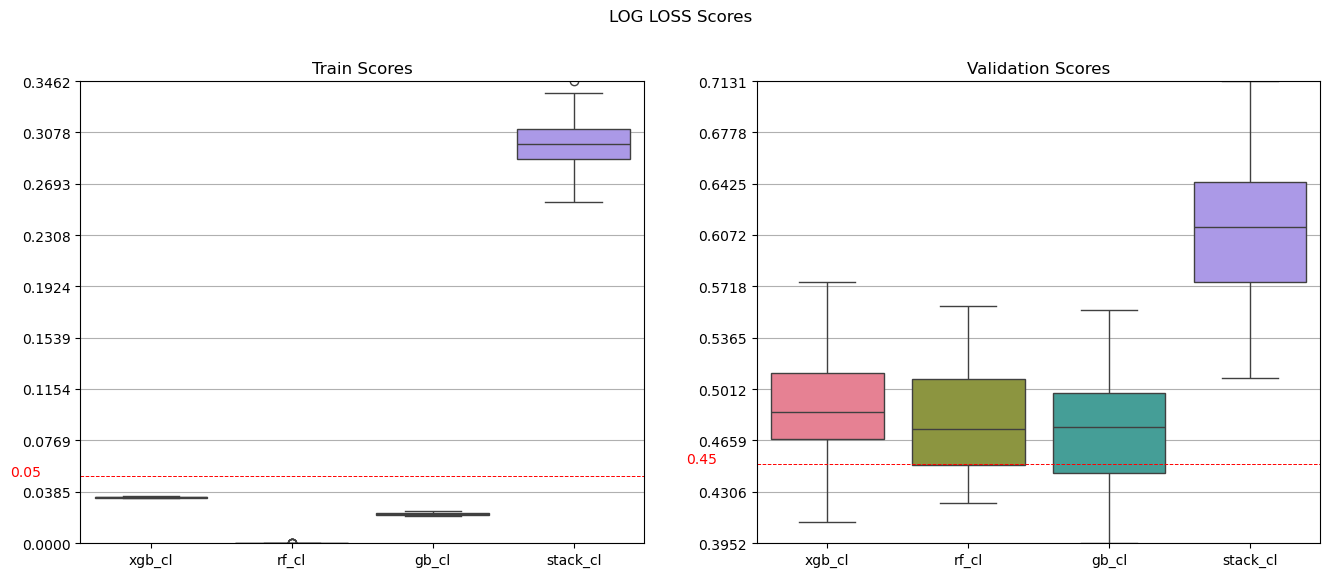

In [148]:
# Plot Log Loss scores for training and validation for each classifier
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

eps = .05
hl_train = .05
hl_val = .45
min_score_train = train_scores.min().min()
max_score_train = train_scores.max().max()
max_score_val = val_scores.max().max()
min_score_val = val_scores.min().min()
def calculate_ticks_train(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

def calculate_ticks_val(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks_train = calculate_ticks_train(min_score_train, max_score_train)
ticks_val = calculate_ticks_val(min_score_val, max_score_val)


_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score_train, max_score_train)
_ = axes[0].set_yticks(ticks_train)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=hl_train, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl_train, f"{hl_train}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score_val, max_score_val)
_ = axes[1].set_yticks(ticks_val)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=hl_val, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl_val, f"{hl_val}", c="red")

fig.suptitle("LOG LOSS Scores", y=1)  # Add a common title above the subplots
plt.show()


       XGB Train  XGB Validation      RF Train  RF Validation   GB Train  \
count  30.000000       30.000000  3.000000e+01      30.000000  30.000000   
mean    0.034223        0.489466  2.720224e-04       0.480670   0.022031   
std     0.000398        0.039255  1.383364e-04       0.038927   0.001058   
min     0.033510        0.409572  4.440892e-16       0.422600   0.020144   
25%     0.033901        0.466659  3.400281e-04       0.449140   0.021302   
50%     0.034224        0.485601  3.400281e-04       0.474032   0.022045   
75%     0.034445        0.512110  3.400281e-04       0.508315   0.022537   
max     0.035212        0.574815  3.400281e-04       0.558437   0.024332   

       GB Validation  
count      30.000000  
mean        0.473415  
std         0.039454  
min         0.395238  
25%         0.443638  
50%         0.475065  
75%         0.498596  
max         0.555484  


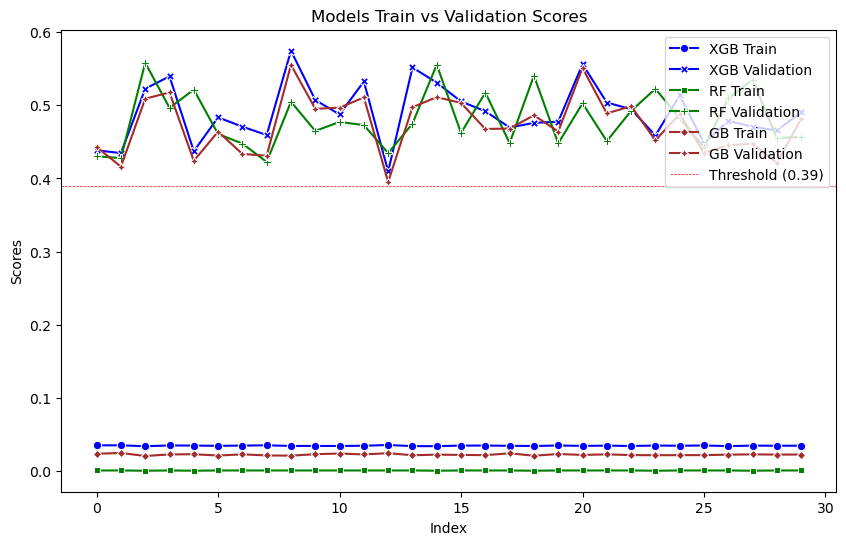

In [149]:
# Plot training and validation performance for each classifier after every fold

xgb_train_scores = train_scores["xgb_cl"]
xgb_val_scores = val_scores["xgb_cl"]
rf_train_scores = train_scores["rf_cl"]
rf_val_scores = val_scores["rf_cl"]
gb_train_scores = train_scores["gb_cl"]
gb_val_scores = val_scores["gb_cl"]

# Print results in DataFrame
model_res = pd.concat([xgb_train_scores.describe(), xgb_val_scores.describe(), rf_train_scores.describe(), rf_val_scores.describe(), gb_train_scores.describe(),gb_val_scores.describe()], axis=1)
model_res.columns = ['XGB Train', 'XGB Validation', 'RF Train', 'RF Validation', 'GB Train', 'GB Validation']
print(model_res)

# Plot results as lineplot
plt.figure(figsize=(10, 6))
_ = sns.lineplot(data=pd.concat([xgb_train_scores, xgb_val_scores, rf_train_scores, rf_val_scores, gb_train_scores, gb_val_scores], keys=["XGB Train", "XGB Validation", "RF Train", "RF Validation", 'GB Train', 'GB Validation'], axis=1), markers=True, dashes=False, palette=["blue", "blue", "green", "green", 'brown','brown'])
plt.axhline(y=0.39, color='r', linestyle='--', lw=.5, label='Threshold (0.39)')

# Set the same color for both lines in the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(loc='upper right')

plt.title('Models Train vs Validation Scores')
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()


In [150]:
class MyAvgVoting(BaseEstimator, ClassifierMixin):
    """A basic voting method that just averages all estimator predictions and 
    predicts the class with the highest vote."""
    def __init__(self, estimators, weighted=False):
        self.estimators = estimators
        # Whether to average according to validation scores
        self.weighted = weighted

    def fit(self, X, y):
        for _, est in self.estimators:
            est["model"].fit(X, y)
        return self
    
    def create_avg_prob_predictions(self, X):
        predictions = np.array([est["model"].predict_proba(X) for est in self.estimators])
        if self.weighted:
            # Note: we need the inverse of the val_score since lower values are "better"
            weights = [{"name": est["name"], "value": 1/est["avg_val_score"]} for est in self.estimators]
            print(f"Weights are:\n{pd.DataFrame(weights)}")
            return np.average(predictions, axis=0, weights=[w["value"] for w in weights])
        return np.average(predictions, axis=0)
            
    def predict(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return np.argmax(avg_predictions, axis=1)

    def predict_proba(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return avg_predictions

    def score(self, X, y):
        pass

voting_ests = models
voting_clf = MyAvgVoting(voting_ests, weighted=False) 
# no fitting needed

#### Classification Report

##### Best Parameters each model

In [151]:
# Classification report for all models in models
for model in models:
    y_pred_train = model['model'].predict(df_train_final[model['feats']])
    y_pred_test = model['model'].predict(df_test_final[model['feats']])
    print(f"{model['name']}(): ")
    print(f"Classification report Training: ")
    print(classification_report(df_train_final[LABEL],y_pred_train))
    print(f"\nClassification Report Testing: ")
    print(classification_report(df_test_final[LABEL],y_pred_test))
    print()


xgb_cl(): 
Classification report Training: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1865
           1       0.94      0.81      0.87       800
           2       0.87      0.93      0.90      1865

    accuracy                           0.89      4530
   macro avg       0.90      0.87      0.88      4530
weighted avg       0.89      0.89      0.89      4530


Classification Report Testing: 
              precision    recall  f1-score   support

           0       0.96      0.87      0.92      1490
           1       0.69      0.76      0.72        82
           2       0.80      0.93      0.86       800

    accuracy                           0.89      2372
   macro avg       0.82      0.85      0.83      2372
weighted avg       0.90      0.89      0.89      2372


rf_cl(): 
Classification report Training: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1865
        

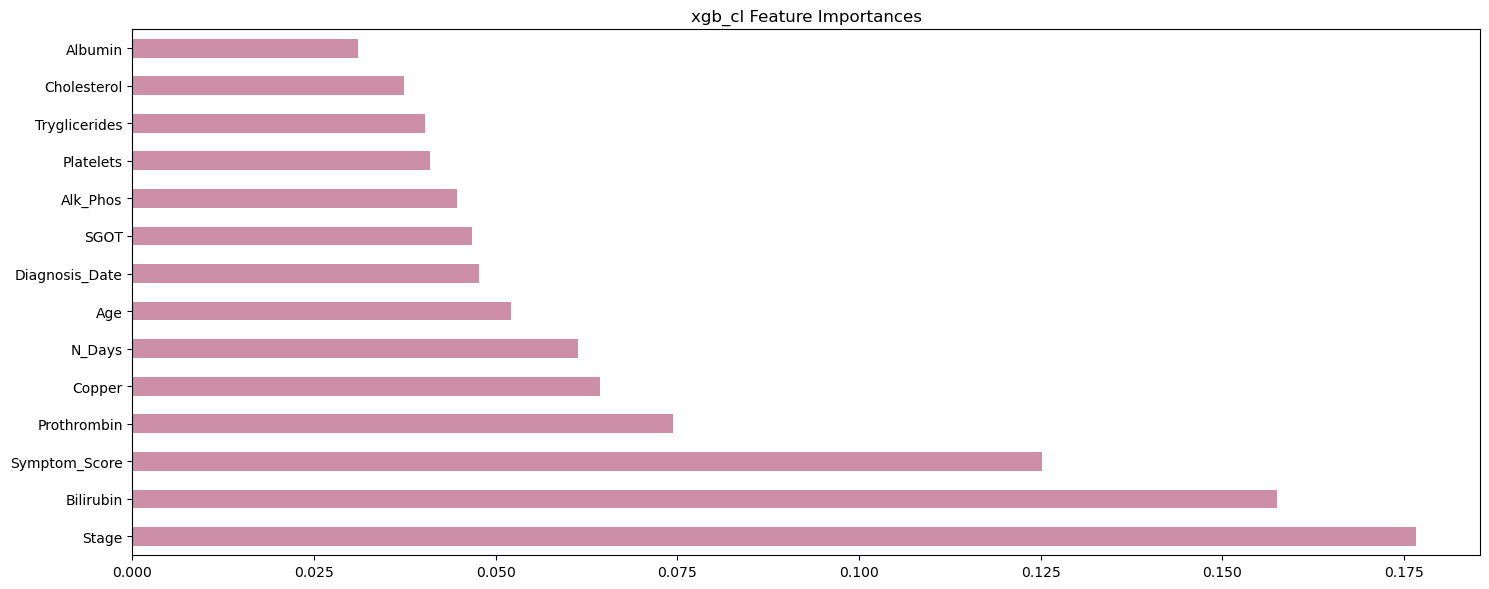

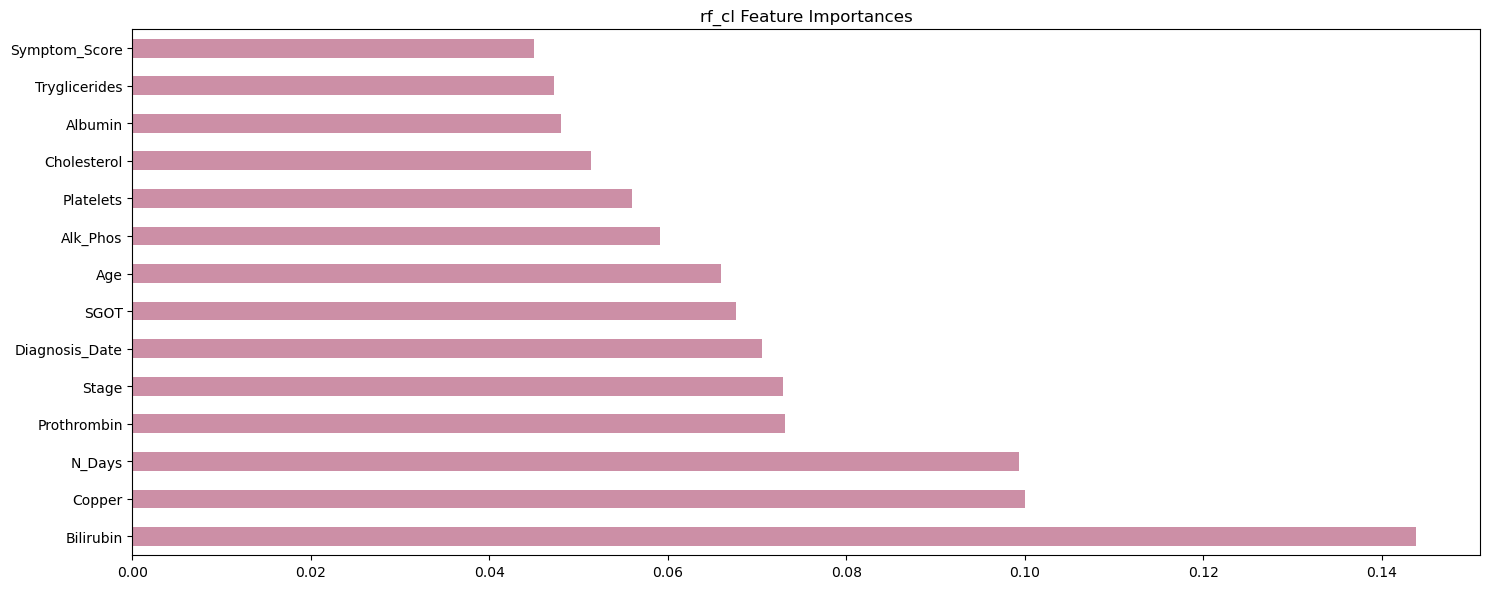

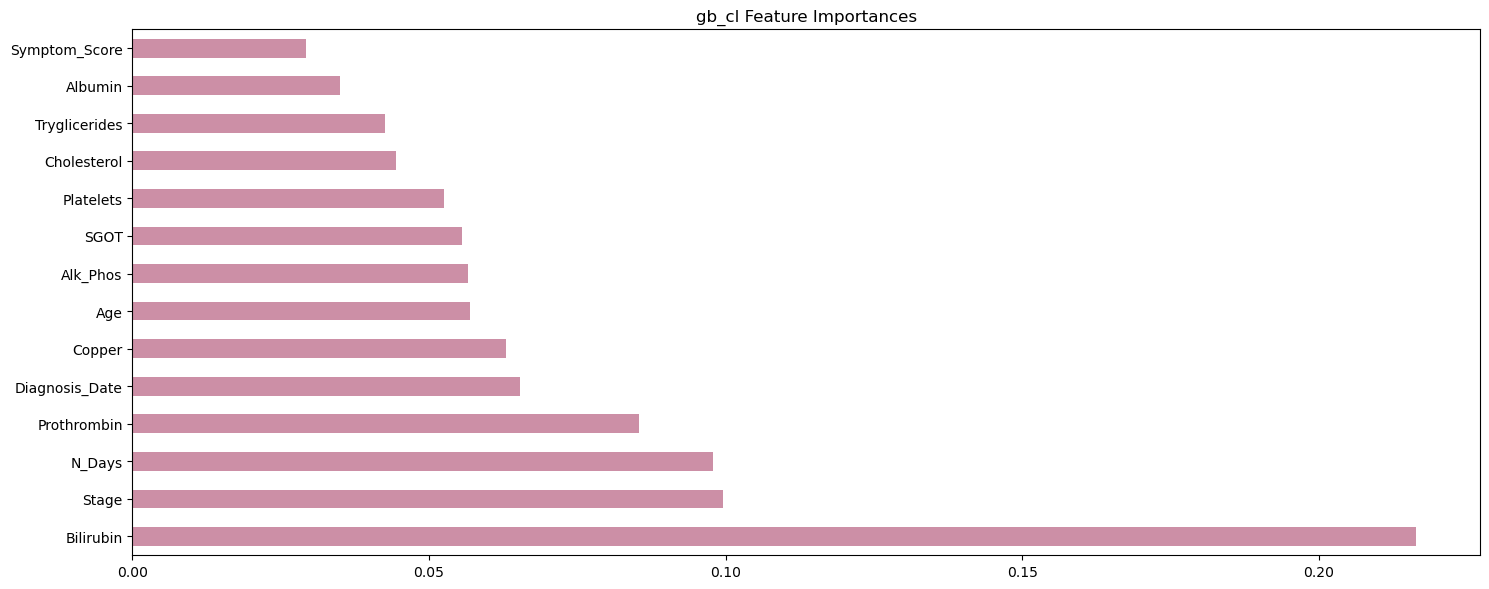

AttributeError: 'StackingClassifier' object has no attribute 'feature_importances_'

In [152]:
# Plot feature importances for each model
for model in models:
    feat_importances = pd.Series(model['model'].feature_importances_, index=df_train_final[FEATS].columns)

    # Plotting both feature importances in subplots
    fig, axes = plt.subplots(1, 1, figsize=(15, 6))

    feat_importances.nlargest(20).plot(kind='barh', title=f"{model['name']} Feature Importances")

    plt.tight_layout()
    plt.show()
    # print(f"Total sorted  importances: {feat_importances.nlargest(99).index.tolist()}")